In [80]:
import numpy as np
import matplotlib.pyplot as plt

In [81]:
# Common variable and plotting function

beta = 0.5
j_fulladder = np.array([
    [0, -1, -1, 1, 2],
    [-1, 0, -1, 1, 2],
    [-1, -1, 0, 1, 2],
    [1, 1, 1, 0, -2],
    [2, 2, 2, -2, 0],
], dtype=np.float64)

def plot_cbit_dynamics(ts: np.ndarray, xs: np.ndarray, ms: np.ndarray):

    fig, ax = plt.subplots(2, 1, figsize=(5, 5))

    ax[0].plot(ts, xs, label=[f'x_{i}' for i in range(xs.shape[1])])
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('x')
    ax[0].legend()
    ax[0].set_title('State Variables Dynamics')

    ax[1].plot(ts, ms, label=[f'm_{i}' for i in range(ms.shape[1])], drawstyle='steps-post')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('m')
    ax[1].legend()
    ax[1].set_title('Chaotic Bit Dynamics')

    plt.tight_layout()
    plt.show()


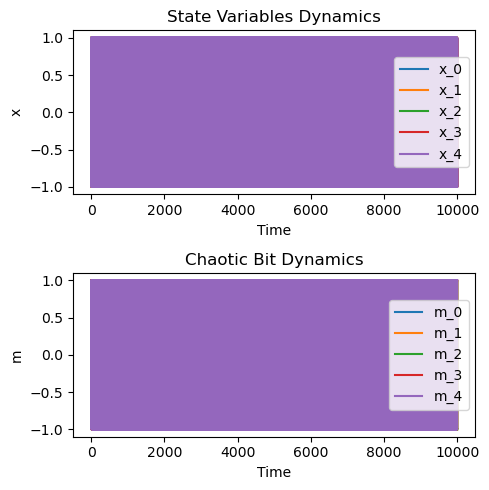

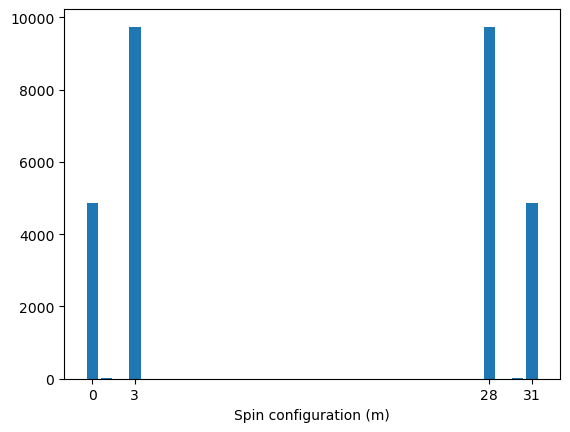

In [82]:
# Event-based simulation

def sim(x: np.ndarray, m: np.ndarray, beta: np.ndarray, j_matrix: np.ndarray, h_vec: np.ndarray, t1: float) -> tuple[np.ndarray, np.ndarray,np.ndarray]:
    """Simulate the chaotic Ising machine with event-based simulation.

    Args:
        x: The state of the system.
        m: The `spin` of c-bit states.
        beta: The inverse temperature.
        j_matrix: The interaction weight matrix.
        h_vec: The bias vector.
    Returns:
        The x and m state of the system and time points.
    """
    t = 0
    xs = [x]
    ms = [m]
    ts = [t]
    while t < t1:
        ising = np.matmul(j_matrix, m) + h_vec
        slope = -m + np.tanh(beta * ising)
        event_time = np.min((-m - xs[-1]) / slope)
        t += event_time
        n_x = xs[-1] + event_time * slope
        m = np.where(n_x >= 1, 1, np.where(n_x <= -1, -1, m))
        xs.append(n_x)
        ms.append(m)
        ts.append(t)
    return  np.stack(xs), np.stack(ms), np.array(ts)

t_end = 0.1 * 10 ** 5
x_vec_init = np.ones(j_fulladder.shape[1])
h_vec = np.zeros(j_fulladder.shape[1])
m_vec = np.ones(j_fulladder.shape[1])
xs_eb, ms_eb, ts_eb = sim(x_vec_init, m_vec, beta, j_fulladder, h_vec, t_end)

plot_cbit_dynamics(ts_eb, xs_eb, ms_eb)
# Plot the `m` distribution
ms_decimal = np.dot((ms_eb + 1) / 2, 2 ** np.arange(0, ms_eb.shape[1])[::-1])
m_vals = [i for i in range(2 ** ms_eb.shape[1])]
ms_cnt = [0 for _ in m_vals]
for m in ms_decimal:
    ms_cnt[int(m)] += 1
bar = plt.bar(m_vals, ms_cnt)
plt.xticks([0, 3, 28, 31])
plt.xlabel('Spin configuration (m)')
plt.show()

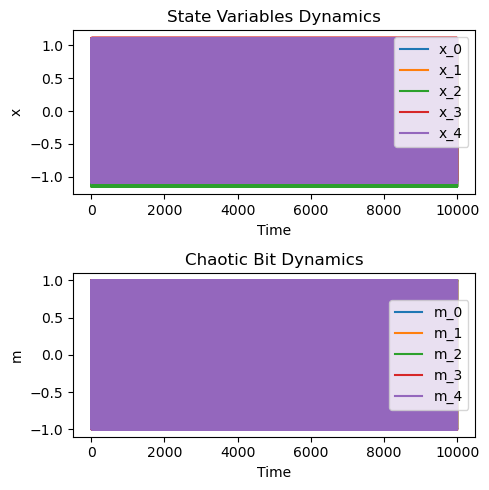

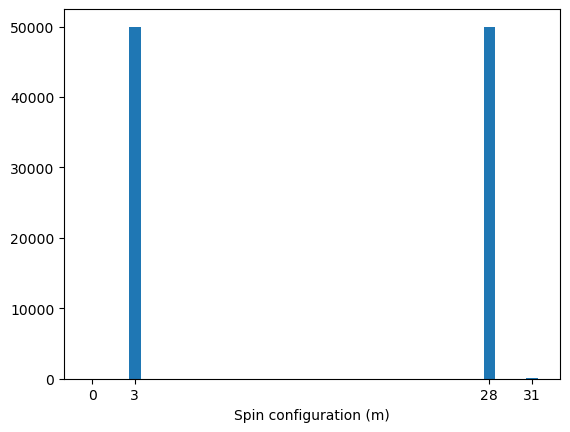

In [83]:

import numba as nb

@nb.njit
def sim_cbit_1st_order_euler(dt: float, n_time_steps: int):
    """Simulate the chaotic Ising machine with 1st order Euler method.

    Args:
        dt: The time step.
        n_time_steps: The number of time steps.
    """
    x_vec_init = np.ones(j_fulladder.shape[1])
    m_vec = np.ones(j_fulladder.shape[1])
    h_vec = np.zeros(j_fulladder.shape[0])

    x_vecs = [x_vec_init]
    m_vecs = [m_vec]
    t_vec = [0]

    for _ in range(n_time_steps):
        ising = j_fulladder @ m_vec + h_vec
        x_vecs.append(x_vecs[-1] + dt * (-m_vec + np.tanh(beta * ising)))
        m_vec = np.where(x_vecs[-1] >= 1, 1, np.where(x_vecs[-1] <= -1, -1, m_vec))
        m_vecs.append(m_vec)
        t_vec.append(t_vec[-1] + dt)

    return x_vecs, m_vecs, t_vec

dt = 0.1
n_time_steps = int(1e5)
x_vecs, m_vecs, t_vecs = sim_cbit_1st_order_euler(dt, n_time_steps)

ts_euler = np.array(t_vecs)
xs_euler, ms_euler = np.array(x_vecs), np.array(m_vecs)
plot_cbit_dynamics(ts_euler, xs_euler, ms_euler)

# Plot the `m` distribution
ms_decimal = np.dot((ms_euler + 1) / 2, 2 ** np.arange(0, ms_euler.shape[1])[::-1])
m_vals = [i for i in range(2 ** ms_euler.shape[1])]
ms_cnt = [0 for _ in m_vals]
for m in ms_decimal:
    ms_cnt[int(m)] += 1
bar = plt.bar(m_vals, ms_cnt)
plt.xticks([0, 3, 28, 31])
plt.xlabel('Spin configuration (m)')
plt.show()

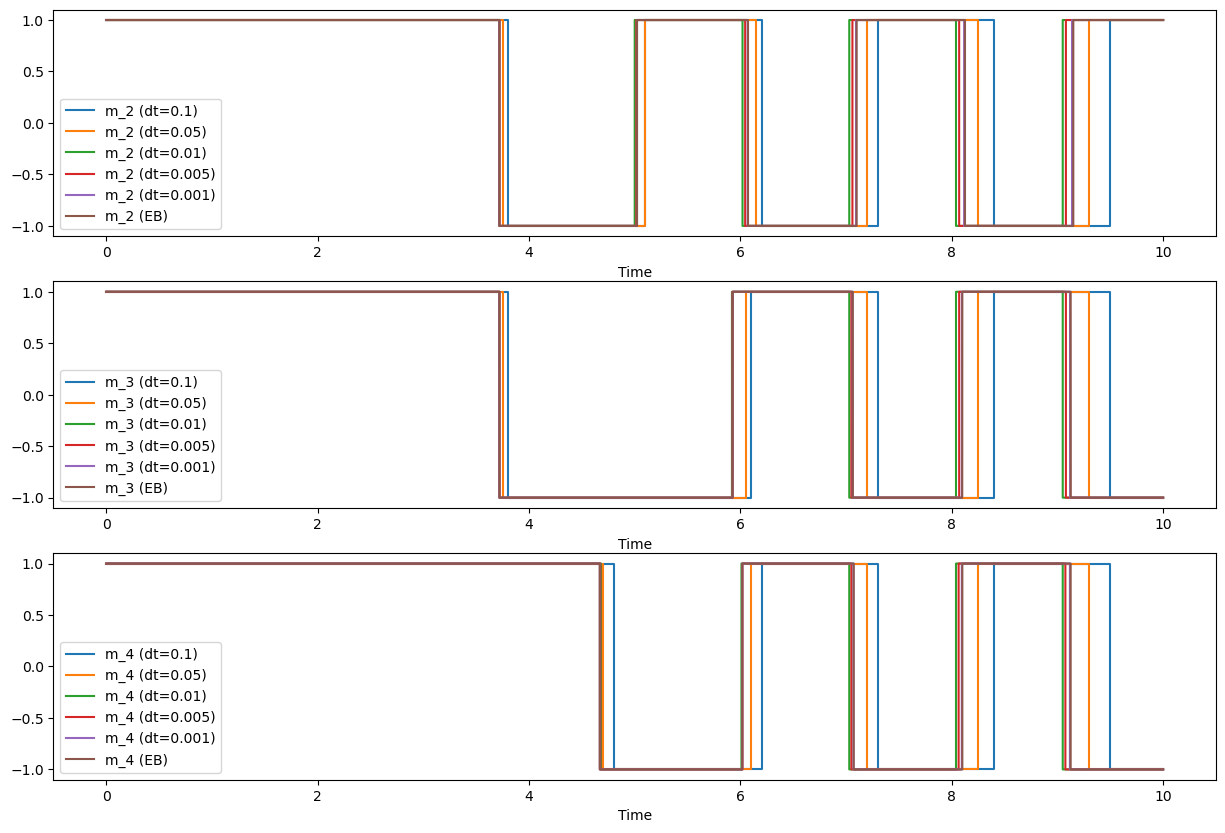

In [84]:
from scipy.interpolate import interp1d

# Sanity check: the first 3 axis should be identical for both x and m
assert np.allclose(xs_euler[:, 0], xs_euler[:, 1]) and np.allclose(xs_euler[:, 0], xs_euler[:, 2])
assert np.allclose(ms_euler[:, 0], ms_euler[:, 1]) and np.allclose(ms_euler[:, 0], ms_euler[:, 2])
assert np.allclose(xs_eb[:, 0], xs_eb[:, 1]) and np.allclose(xs_eb[:, 0], xs_eb[:, 2])
assert np.allclose(ms_eb[:, 0], ms_eb[:, 1]) and np.allclose(ms_eb[:, 0], ms_eb[:, 2])


t1 = 10
fig, ax = plt.subplots(3, 1, figsize=(15, 10))

for dt in [0.1, 0.05, 0.01, 0.005, 0.001]:
    n_time_steps = int(t1 / dt)
    x_vecs, m_vecs, t_vecs = sim_cbit_1st_order_euler(dt, n_time_steps)
    ts_euler = np.array(t_vecs)
    xs_euler, ms_euler = np.array(x_vecs), np.array(m_vecs)

    # Plot x_2~4 and m_2~4
    for i in range(3):
        vec_id = i + 2
        # ax[i].plot(ts_euler, xs_euler[:, vec_id], label=f'x_{vec_id} (dt={dt})')
        ax[i].plot(ts_euler, ms_euler[:, vec_id], label=f'm_{vec_id} (dt={dt})', drawstyle='steps-post')
        ax[i].set_xlabel('Time')
        ax[i].legend()

    


x_vec_init = np.ones(j_fulladder.shape[1])
h_vec = np.zeros(j_fulladder.shape[1])
m_vec = np.ones(j_fulladder.shape[1])
xs_eb, ms_eb, ts_eb = sim(x_vec_init, m_vec, beta, j_fulladder, h_vec, t1)
# Compare the traces from the event-based simulation and 1st order Euler method
# Interpolate xs_eb linearly with respect to ts_euler
xs_eb_interp = interp1d(ts_eb, xs_eb, axis=0)(ts_euler)

# Interpolate ms_eb step-wise with respect to ts_euler
ms_eb_interp = interp1d(ts_eb, ms_eb, axis=0, kind='previous')(ts_euler)

for i in range(3):
    vec_id = i + 2
    # ax[i].plot(ts_euler, xs_eb_interp[:, vec_id], label=f'x_{vec_id} (EB)')
    ax[i].plot(ts_euler, ms_eb_interp[:, vec_id], label=f'm_{vec_id} (EB)', drawstyle='steps-post')
    ax[i].set_xlabel('Time')
    ax[i].legend()
plt.show()





## Failed attempt to simulate cbits with Jax

In [85]:
import jax.numpy as jnp
import diffrax
import jax
from jaxtyping import Array, DTypeLike

jax.config.update("jax_enable_x64", True)


In [86]:

def ode_fn(t: DTypeLike, y: Array, args: list[Array]) -> Array:
    """The derivative function of the chaotic Ising machine.

    m_i = 
        - 1 if x_i >= 1
        - -1 if x_i <= -1
        - m_i otherwise
    dx_i/dt = -x_i + tanh(beta * J @ m + h)
    
    Args:
        t: The time.
        y: The current state of the system.
        args: The parameters of the system, including
        - beta: The inverse temperature.
        - j_matrix: The interaction weight matrix.
        - h_vec: The bias vector.    
        - m_vec: The `spin` of c-bit states.
    Returns:
        The derivative of the state.
    """
    beta, j_matrix, h_vec, m_vec = args
    m_vec = jnp.where(y >= 1, 1, jnp.where(y <= -1, -1, m_vec))
    args[-1] = m_vec
    ising = jnp.matmul(j_matrix, m_vec) + h_vec
    return -m_vec + jnp.tanh(beta * ising)


In [87]:
# Use the paper parameters
dt = 0.1
n_time_steps = 10 ** 3
t_end = dt * n_time_steps
time_points = jnp.linspace(0, t_end, n_time_steps, endpoint=True)
beta = 0.5

j_fulladder = jnp.array([
    [0, -1, -1, 1, 2],
    [-1, 0, -1, 1, 2],
    [-1, -1, 0, 1, 2],
    [1, 1, 1, 0, -2],
    [2, 2, 2, -2, 0],
])
x_vec_init = jnp.ones(j_fulladder.shape[1])
m_vec = jnp.ones(j_fulladder.shape[1])
h_vec = jnp.zeros(j_fulladder.shape[0])

solver = diffrax.Euler()
args = [beta, j_fulladder, h_vec, m_vec]

solution = diffrax.diffeqsolve(
    terms=diffrax.ODETerm(ode_fn),
    solver=solver,
    t0=0,
    t1=t_end,
    dt0=dt,
    y0=x_vec_init,
    saveat=diffrax.SaveAt(ts=time_points),
    args=args,
)


UnexpectedTracerError: Encountered an unexpected tracer. A function transformed by JAX had a side effect, allowing for a reference to an intermediate value with type float64[5] wrapped in a DynamicJaxprTracer to escape the scope of the transformation.
JAX transformations require that functions explicitly return their outputs, and disallow saving intermediate values to global state.
The function being traced when the value leaked was _fn at /Users/wyn/miniconda3/envs/Ark/lib/python3.11/site-packages/equinox/_eval_shape.py:31 traced for jit.
------------------------------
The leaked intermediate value was created on line /var/folders/zv/1cq_05k97dl9b9_kf_drhmdr0000gp/T/ipykernel_62971/1895867726.py:22:12 (ode_fn). 
------------------------------
When the value was created, the final 5 stack frames (most recent last) excluding JAX-internal frames were:
------------------------------
<frozen runpy>:198:11 (_run_module_as_main)
<frozen runpy>:88:4 (_run_code)
/var/folders/zv/1cq_05k97dl9b9_kf_drhmdr0000gp/T/ipykernel_62971/1433808151.py:22:11 (<module>)
/var/folders/zv/1cq_05k97dl9b9_kf_drhmdr0000gp/T/ipykernel_62971/1895867726.py:22:12 (ode_fn)
------------------------------

To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError

In [ ]:

dt_fixed = dt

def ode_fn(t: DTypeLike, y: Array, args: list[Array]) -> Array:
    """The derivative function of the chaotic Ising machine.
    Approx the spin update with a steep slope.

    dx_i/dt = -x_i + tanh(beta * J @ m + h)
    dm_i/dt = 
        - 2 / dt if x_i >= 1
        - -2 / dt if x_i <= -1
        - 0 otherwise
    
    Args:
        t: The time.
        y: The current state of the system.
        args: The parameters of the system, including
        - beta: The inverse temperature.
        - j_matrix: The interaction weight matrix.
        - h_vec: The bias vector.    
    Returns:
        The derivative of the state.
    """
    x, m = y[:len(y) // 2], y[len(y) // 2:]
    beta, j_matrix, h_vec= args
    dmdt = jnp.where(x >= 1, 2 / dt_fixed, jnp.where(x <= -1, -2 / dt_fixed, 0))
    m = m + dmdt * dt_fixed # use the updated m
    ising = jnp.matmul(j_matrix, m) + h_vec
    dxdt = -m + jnp.tanh(beta * ising)
    return jnp.concatenate([dxdt, dmdt])


args = [beta, j_fulladder, h_vec]
m_vec = -jnp.ones(j_fulladder.shape[1])

solution = diffrax.diffeqsolve(
    terms=diffrax.ODETerm(ode_fn),
    solver=solver,
    t0=0,
    t1=t_end,
    dt0=dt,
    y0=jnp.concatenate([x_vec_init, m_vec]),
    saveat=diffrax.SaveAt(ts=time_points),
    args=args,
)

# Plot the solution
import matplotlib.pyplot as plt

print(solution.ys.shape)
plt.plot(solution.ts, solution.ys[:, :5])
plt.title("x")
plt.show()
plt.plot(solution.ts, solution.ys[:, 5:])
plt.title("m")
plt.show()